# Нетология. Математическая статистика в python.

# Лекция 4. Кейс-стади. Классификационные задачи.
# Датасет неисправностей стальных плат

In [1]:
# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st
import statsmodels as sm
import matplotlib
import pandas as pd
import io
import requests
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline


Загрузим датасет 'Faulty-steel-plates' с kaggle: (ссылка - https://www.kaggle.com/uciml/faulty-steel-plates)

В датасете имеется 7 неиправностей стальной платы и некие параметры данных плат (27 атрибутов)

In [2]:
import io
import requests
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
url="faults.csv"
dataset_temp=pd.read_csv(url) 
dataset_temp.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


В данном датасете 34 атрибута. Первые 27 атрибутов описывают некоторые неиправности стальной платы, которые были замечены в изображениях.

*    X_Minimum
*   X_Maximum
*    Y_Minimum
*    Y_Maximum
*    Pixels_Areas
*    X_Perimeter
*    Y_Perimeter
*    Sum_of_Luminosity
*    Minimum_of_Luminosity
*    Maximum_of_Luminosity
*    Length_of_Conveyer
*    TypeOfSteel_A300
*    TypeOfSteel_A400
*    Steel_Plate_Thickness
*    Edges_Index
*    Empty_Index
*    Square_Index
*    Outside_X_Index
*    Edges_X_Index
*    Edges_Y_Index
*    Outside_Global_Index
*    LogOfAreas
*    Log_X_Index
*    Log_Y_Index
*    Orientation_Index
*    Luminosity_Index
*    SigmoidOfAreas

Последние 7 колонок - это класс, к которому относится то или иное повреждение (one-hot-encoding). Например, если какой-либо элемент классифицируется как "Stains" (пятна), то в колонке 'Stains' 
будет стоять единица. Последние 7 атрибутов представляют собой класс для каждого элемента.

*    Pastry
*    Z_Scratch
*    K_Scatch
*    Stains
*    Dirtiness
*    Bumps
*    Other_Faults


Первые 27 колонок данной таблицы являются колонками для предсказаний класса.


In [3]:
data = dataset_temp.iloc[:,:27]
data[:4]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212



Посмотрим частотный график данных колонок (график histograms):

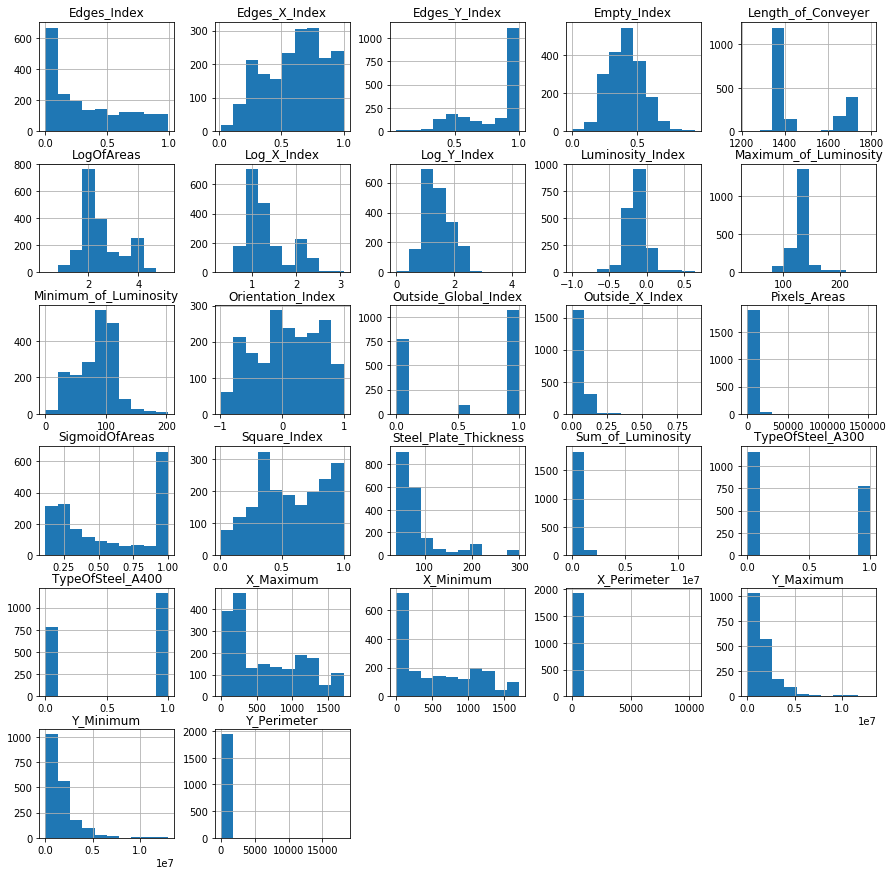

In [4]:
data.hist(figsize=(15,15))
plt.show()


Из данных графиков можно увидеть, что Outside_Global_Index, TypeOfSteel_A300, TypeOfSteel_A400 являются дискретными величинами со значениями [0, 0.5, 1], [0,1], [0,1] соответственно (распределение Бернулли).

Можно также заметить, что такие переменные, как **Empty_Index**, **Log_Y_Index**, **Luminosity_Index** являются распределением, близким к нормальному распределению Гаусса.

Выделим колонки в отдельный список

In [5]:
headers = list(data.columns.values)

**Нормализуем** параметры

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(data)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,...,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,...,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,...,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,...,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,...,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


При нормализации стираются названия колонок, поэтому необходимо **восстановить** их:

In [7]:
df_norm.columns = headers
df_norm.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,...,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,...,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,...,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,...,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,...,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


In [8]:
len(df_norm)

1941

Построим матрицу корреляций:

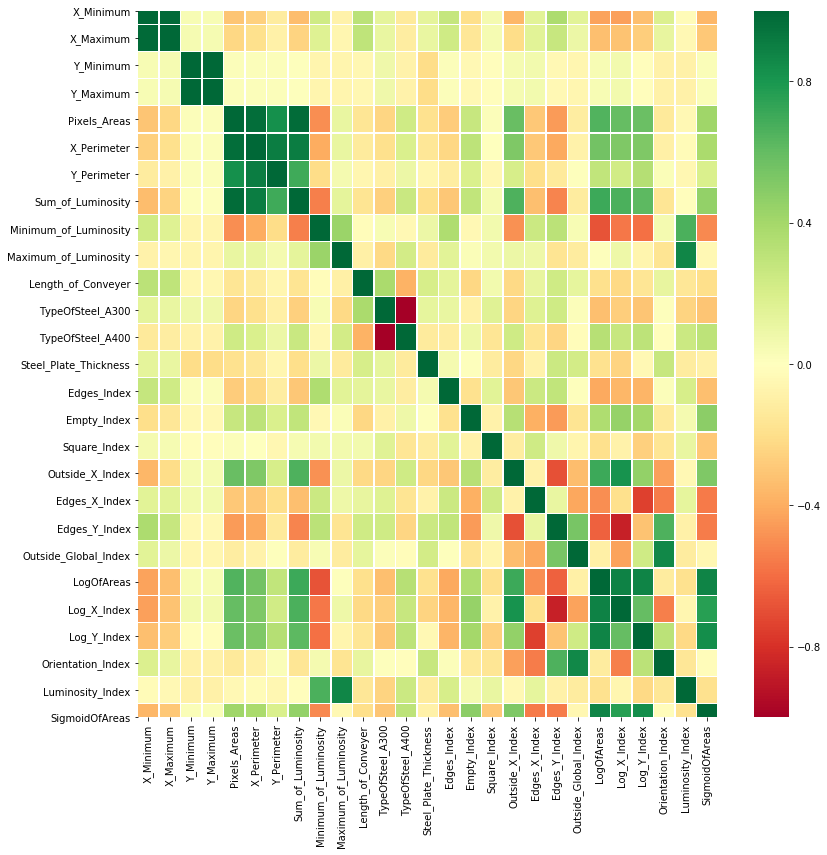

In [9]:
f, ax = plt.subplots(figsize=(13, 13))
corr = np.round_(df_norm.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

Некоторые переменные сильно коррелированы (например, Sum_of_Luminosity и Pixels_areas)

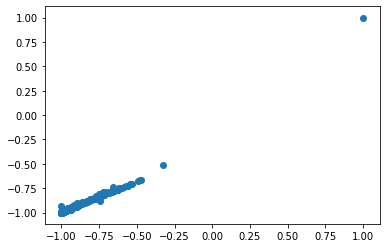

In [10]:
plt.scatter(df_norm['Sum_of_Luminosity'], df_norm['Pixels_Areas'])
plt.show()

# Выбросы. Boxplot

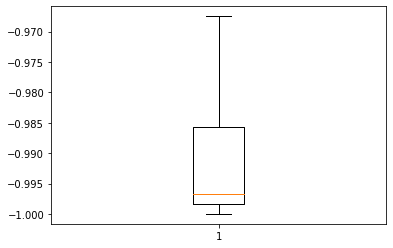

In [11]:
from pylab import *
r = boxplot(df_norm['Sum_of_Luminosity'], showfliers=False) 

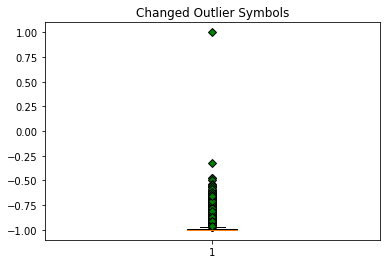

In [12]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Changed Outlier Symbols')
ax3.boxplot(df_norm['Sum_of_Luminosity'], flierprops=green_diamond)
plt.show()

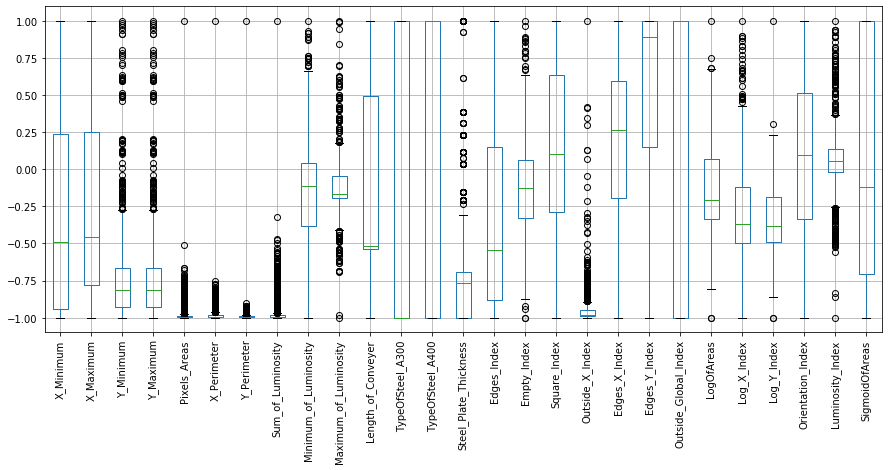

In [13]:
boxplot = df_norm.boxplot(figsize=(15,6), rot=90)

Можно заметить, что в данном графике есть выбросы в некоторых атрибутах.

Можно удалить все элементы, **выходящие за 1ый и 3ий квартили**. Посчитаем эти квартили для всех колонок:

In [14]:
low = .05
high = .95
quant_df = df_norm.quantile([low, high])

Удалить данные, выходящие за квартили:

In [15]:
filt_df = df_norm.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

Посмотрим, что получилось после удаления элементов вне интерквартильного интервала:

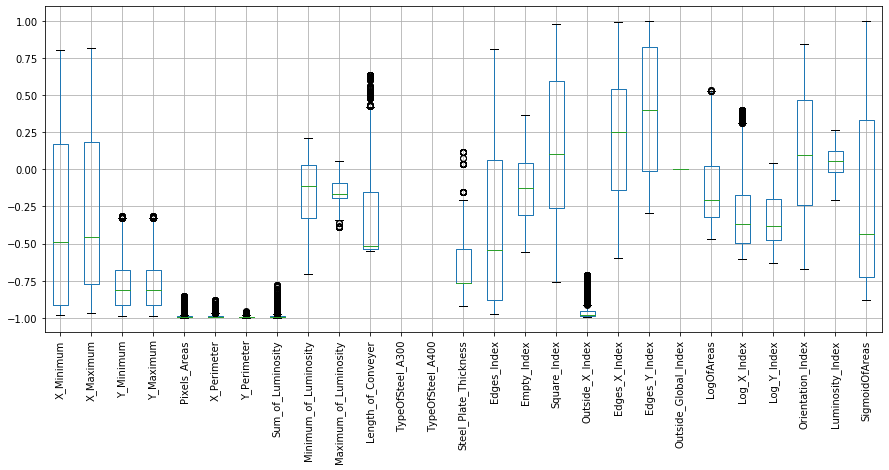

In [16]:
boxplot = filt_df.boxplot(figsize=(15,6), rot=90)

Картина после удаления выбросов улучшилась, но выбросы в некоторых атрибутах остались => можно например улучшать дальше (выбрать 50% квантиль например.)

Удалим элементы за 20% и 80% квантилями.

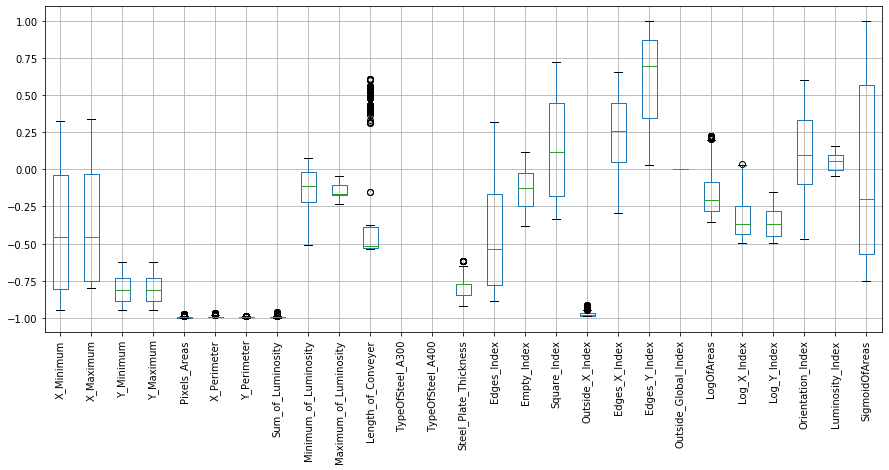

In [17]:
low = .2
high = .8
quant_df = df_norm.quantile([low, high])
filt_df_2 = df_norm.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)
boxplot = filt_df_2.boxplot(figsize=(15,6), rot=90)

Таким образом, картина стала четче и данные более понятны.

# Тест на нормальное распределение:

In [18]:
k2, p = stats.normaltest(df_norm['Sum_of_Luminosity'])
alpha = 0.01
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Не нормальное распределение для alpha = ", alpha)
else:
    print("Нормальное распределение для alpha = ", alpha)

p = 0
Не нормальное распределение для alpha =  0.01


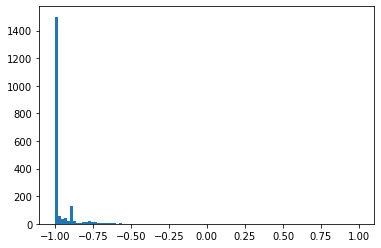

In [19]:
plt.hist(df_norm['Sum_of_Luminosity'], 100)
plt.show()

# Тест на экспоненциальное распределение

Похоже на экспоненциальное распределение. Проверим статистически является ли данное распределение экспоненциальным.

In [20]:
from statsmodels.stats.diagnostic import lilliefors
# If the pvalue is lower than some threshold, e.g. 0.05, 
# then we can reject the Null hypothesis that the sample comes from a normal distribution.
ksstat, pvalue = lilliefors(df_norm['Sum_of_Luminosity'], dist='exp')
print('pvalue: ', pvalue)
alpha = 0.05
if pvalue < alpha:
    print('не экспоненциальное распределение')
else:
    print('экспоненциальное распределение для alpha = ', alpha)

pvalue:  0.01
не экспоненциальное распределение


# Тест на логнормальное распределение

Является ли распределение логнормальным? Распределение является логнормальным, если логарифм распределения является нормальным распределением

In [21]:
# testing for lognormality
# the data is lognormal if np.log(data) is normal
alpha = 0.01
_, pvalx = stats.shapiro(np.log(df_norm['Sum_of_Luminosity']))
print("p-value  = ", pvalx)
print("не является логнормальным для alpha = " + str(alpha)
      if pvalx<alpha  else "является логнормальным для alpha = " + str(alpha))

p-value  =  1.0
является логнормальным для alpha = 0.01


# Тест на гамма распределение 

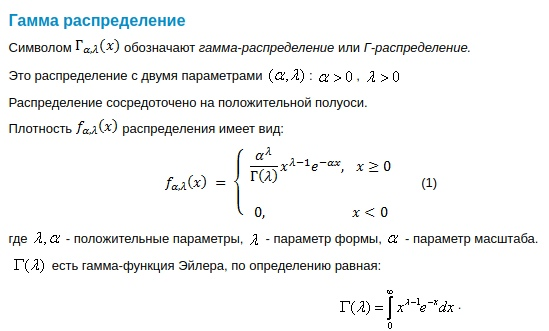

In [22]:
from IPython.display import Image
Image('https://sun9-61.userapi.com/c206820/v206820775/772d1/hlhuLkw198c.jpg')

In [23]:
dist = stats.gamma
args = dist.fit(dataset_temp['Sum_of_Luminosity'])
print('Вычисленные параметры для гамма-распределения:')
print('alpha, loc, beta')
print(args)

Вычисленные параметры для гамма-распределения:
alpha, loc, beta
(0.16843384017846283, 11591413.999999998, 7.097138314008937)


Мы вычисляем параметры для гамма-распределения (допустим, рассматриваемое распределение является гамма-распределением. Чему равно мат ожидание? Чему равны alpha и beta параметры? Мы считаем их с помощью метода stats.gamma.fit)

In [24]:
k2, p = stats.kstest(dataset_temp['Sum_of_Luminosity'], dist.cdf, args)
alpha = 0.01
if p<0.01:
    print('не гамма-распределение для alpha=', alpha)
else:
    print('гамма-распределение для alpha=',alpha)

не гамма-распределение для alpha= 0.01


# Рассмотрим атрибут - Pixels_Areas. Какое это распределение?

In [25]:
k2, p = stats.normaltest(df_norm['Pixels_Areas'])
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Не нормальное распределение для alpha значения = ", str(alpha))
else:
    print("Нормальное распределение для alpha значения = ", str(alpha))

p = 0
Не нормальное распределение для alpha значения =  0.05


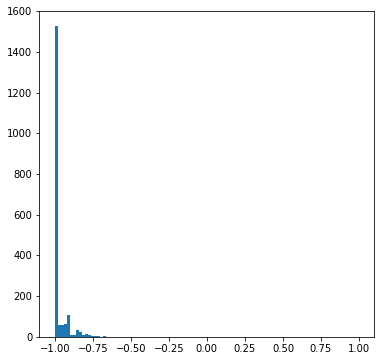

In [26]:
plt.figure(figsize=(6,6))
plt.hist(df_norm['Pixels_Areas'], 100)
plt.show()

# Какое распределение 'Empty_Index'? По графику похоже на нормальное.

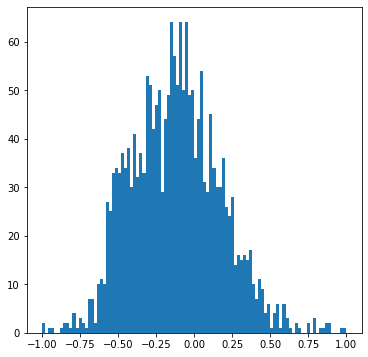

In [27]:
plt.figure(figsize=(6,6))
plt.hist(df_norm['Empty_Index'], 100)
plt.show()

Следующий код проверяет на какое распределение похожа выборка из заданных распределений.
Параметр param_bins нужно поставить таким, чтобы его значение было не больше размера выборки. 

https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

Text(0, 0.5, 'Frequency')

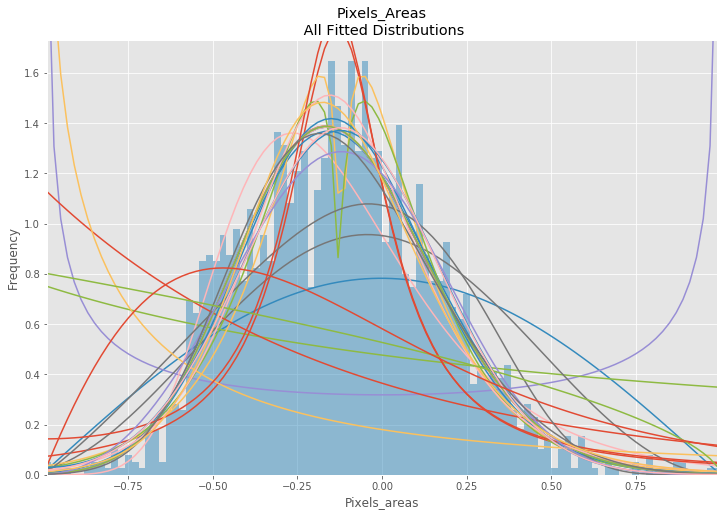

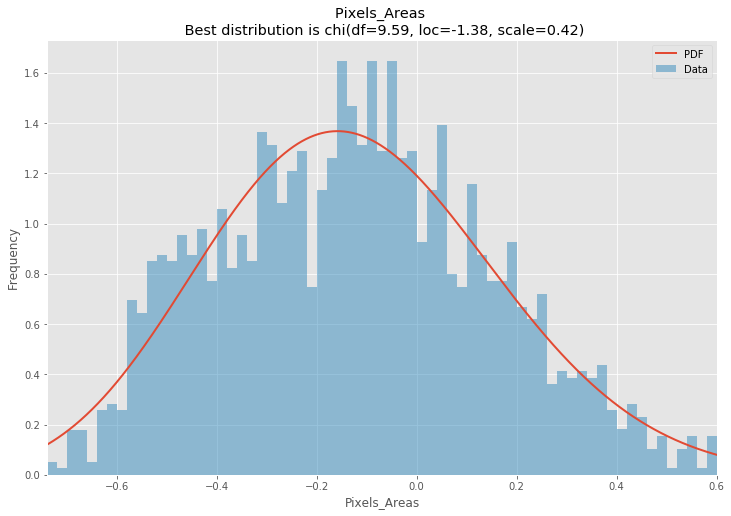

In [28]:
import scipy.stats as st

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

param_bins = 100

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
#        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
#        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
#        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
#        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
#        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
#        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
#        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df_norm['Empty_Index']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=param_bins, normed=True, alpha=0.5, color=list(plt.rcParams['axes.prop_cycle'])[1]['color'])
            #   plt.rcParams['axes.prop_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, param_bins, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Pixels_Areas\n All Fitted Distributions')
ax.set_xlabel(u'Pixels_areas')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=param_bins, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Pixels_Areas \n Best distribution is ' + dist_str)
ax.set_xlabel(u'Pixels_Areas')
ax.set_ylabel('Frequency')

Из всех заданных распределений больше всего похоже на **chi.**

# Уменьшение размерности таблицы - мультиколлинеарность

**Удаление мультиколлинеарности**

Удалим из таблицы значения с корреляцией, большей чем 95%: некоторые атрибуты имеют сильную корреляцию с другими атрибутами, нет смысла использовать два атрибута совместно.

In [31]:
# создаем матрицу корреляций
corr_matrix = df_norm.corr().abs()

# Выбираем верхний треугольник матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Ищем индексы колонок с корреляцией большей чем 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

[]


Удаляем колонки, которые коррелируют максимально друг с другом:

In [32]:
df_norm = df_norm.drop(df_norm[to_drop], axis=1)
df_norm.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.959296,-0.996528,-0.995262,-0.251232,-0.342593,0.622575,1.0,-0.692308,-0.899920,...,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.609987,-0.998611,-0.996805,-0.172414,-0.203704,0.622575,1.0,-0.692308,0.536777,...,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.761620,-0.999096,-0.998017,-0.024631,-0.185185,0.396825,1.0,-0.538462,0.951367,...,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,-0.944125,-0.997720,-0.995152,-0.024631,-0.175926,-0.555556,-1.0,0.923077,0.464429,...,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,-0.924294,-0.968464,-0.971462,-0.635468,-0.175926,-0.555556,-1.0,0.115385,-0.860330,...,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


После удаления остается 22 колонки:

In [31]:
df_norm.shape

(1941, 22)

# Проблема несбалансированности классов: как решать?

Посмотреть разбиение по классам. Сколько элементов в каждом классе?

Pastry	Z_Scratch	K_Scatch	Stains	Dirtiness	Bumps	Other_Faults

In [32]:
print('Количество значений 1го класса: ', dataset_temp[dataset_temp['Pastry']==1].shape)
print('Количество значений 2го класса: ', dataset_temp[dataset_temp['Z_Scratch']==1].shape)
print('Количество значений 3го класса: ', dataset_temp[dataset_temp['K_Scatch']==1].shape)
print('Количество значений 4го класса: ', dataset_temp[dataset_temp['Stains']==1].shape)
print('Количество значений 5го класса: ', dataset_temp[dataset_temp['Dirtiness']==1].shape)
print('Количество значений 6го класса: ', dataset_temp[dataset_temp['Bumps']==1].shape)
print('Количество значений 7го класса: ', dataset_temp[dataset_temp['Other_Faults']==1].shape)


Количество значений 1го класса:  (158, 34)
Количество значений 2го класса:  (190, 34)
Количество значений 3го класса:  (391, 34)
Количество значений 4го класса:  (72, 34)
Количество значений 5го класса:  (55, 34)
Количество значений 6го класса:  (402, 34)
Количество значений 7го класса:  (673, 34)


Количество элементов в каждом классе отличается.

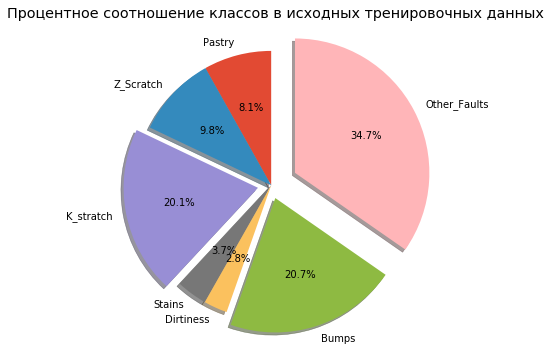

In [33]:
# Построем pie-график
labels = 'Pastry', 'Z_Scratch', 'K_stratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
sizes = [158, 190, 391, 72, 55, 402, 673]
explode = (0, 0, 0.1, 0, 0, 0.1, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots(figsize=(6,6))
plt.title('Процентное соотношение классов в исходных тренировочных данных')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Так как есть несбалансированность классов, необходимо уравнять количество элементов в каждом классе засчет **генерирования новых (up-sampling)** или **удаления элементов (down-sampling)**.

С проблемой классификации с несбалансированными данными хорошо работает **метод решения деревьев**.

# Модель деревья решений (Random Forest) для классификационной задачи

 Задача - определения причины дефекта в металле по параметрам металла, заданого в таблице. Так как классы **несбалансированны**, попробуем для решения составить модель дерева решений.

In [34]:
output_y = dataset_temp.iloc[:,27:]
#input_x = dataset_temp.iloc[:,:27]
input_x = df_norm

Таргет значение представим ввиде **наименований классов.**

In [35]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64


Выделим из датасета тренировочные и тестовые данные. 
Тренировочные данные будем использовать для обучения модели.
Тестовые данные будем использовать для подсчета качества модели.

In [36]:
from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.3)

In [37]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


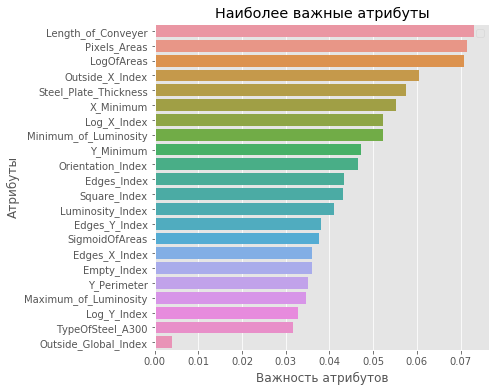

In [38]:
headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Посчитаем качество модели - **classification report**:

In [39]:
model_pred = model.predict(X_test_22)

print(classification_report(y_test_22, model_pred))

model.score(X_test_22, y_test_22)

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       115
           1       0.60      0.46      0.52        13
           2       0.98      0.94      0.96       118
           3       0.72      0.73      0.73       211
           4       0.57      0.55      0.56        42
           5       0.92      1.00      0.96        24
           6       0.89      0.82      0.85        60

    accuracy                           0.77       583
   macro avg       0.76      0.74      0.75       583
weighted avg       0.77      0.77      0.77       583



0.7650085763293311

Модель "рандомных деревьев" дала точность предсказания порядка **77%**.

Мы можем сравнить с теми атрибутами, которые мы удалили, отсекая 10% максимально коррелированных элементов:

In [40]:
['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']

['X_Maximum',
 'Y_Maximum',
 'X_Perimeter',
 'Sum_of_Luminosity',
 'TypeOfSteel_A400']

Получается, мы не удалили наиболее важные элементы для деревьев решений => хороший признак.

# Построим данные в 3D пространстве наиболее важных вектором, обранных моделью Random Forest

Можно отобразить классы (их всего 7) в 3D пространстве наиболее важных атрибутов, отобранных моделью **Random Forest** (Length_of_Conveyer, Outside_X_Index, Log_X_Index):

In [41]:
df = df_norm
df['target'] = Y

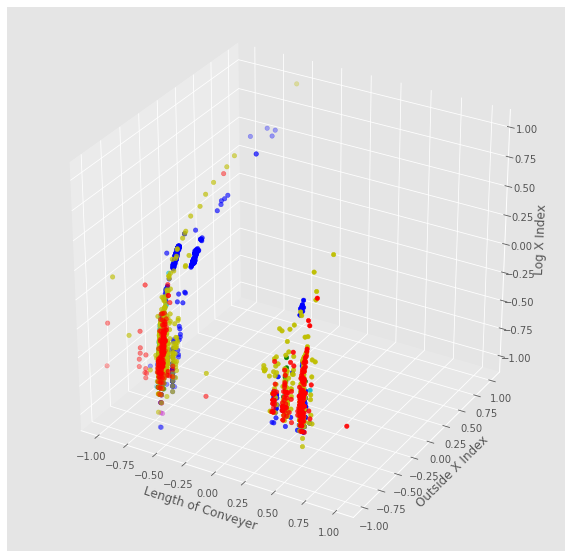

In [42]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Length_of_Conveyer']
  b = df.loc[df['target'] == i, 'Outside_X_Index']
  c = df.loc[df['target'] == i, 'Log_X_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Length of Conveyer')
ax.set_ylabel('Outside X Index')
ax.set_zlabel('Log X Index')
plt.show()

По графику классы не особо различимы. В пространстве классы находятся близко друг к другу.

Можно также посмотреть распределение классов в 3D пространстве по другим атрибутам, например: **{'Steel_Plate_Thickness', 'Edges_Index', 'Outside_Global_Index'}**

In [43]:
df = pd.DataFrame(input_x, columns = ['Steel_Plate_Thickness', 'Edges_Index', 'Outside_Global_Index'])
df['target'] = Y

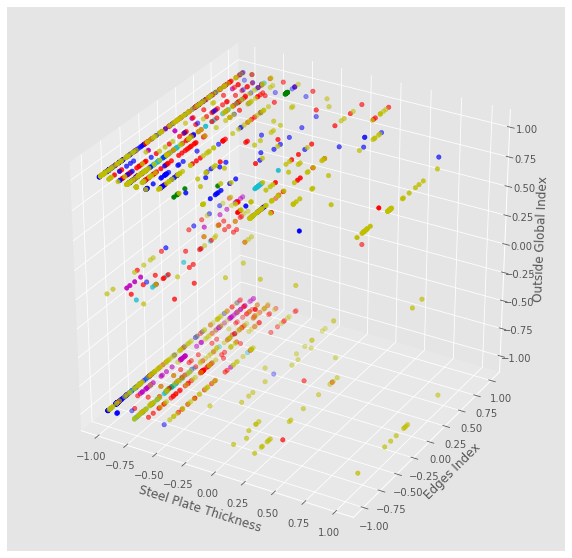

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Steel_Plate_Thickness']
  b = df.loc[df['target'] == i, 'Edges_Index']
  c = df.loc[df['target'] == i, 'Outside_Global_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Steel Plate Thickness')
ax.set_ylabel('Edges Index')
ax.set_zlabel('Outside Global Index')
plt.show()

Как же уменьшить количество атрибутов, при этом оставив данные в пространстве таким образом, чтобы легко можно было классифицировать?

# Принцип минимальных компонент

Почитать про метод - https://ru.wikipedia.org/wiki/Метод_главных_компонент

Соответственно, было 23 атрибута

In [45]:
print(df_norm.shape)

(1941, 23)


Создаем модель PCA

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

Уменьшаем количество атрибутов таблицы, **проецируя все атрибуты в новое пространство**, составленное методом минимальных компонент (всего выбрано **3 самых важных вектора для пространства**)

In [47]:
principalComponents = pca.fit_transform(df_norm)
projected_x = pd.DataFrame(data = principalComponents,
                           columns = ['atribute_1', 'atribute_2', 'atribute_3'])


После применения PCA осталось только 3 атрибута

Таргет значения (**класс дефекта**) не изменился для векторов, **спроецированных в данное пространство**

In [48]:
projected_x['target'] = Y

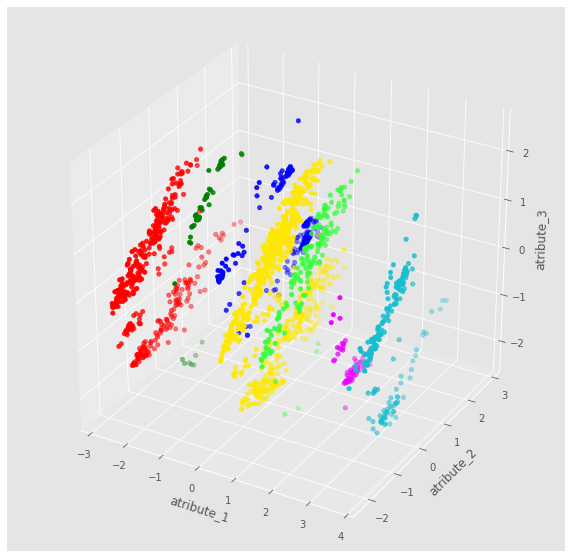

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', '#FFE800', '#33FF39', '#EC00FF', '#17becf']

for i in range(7):
    a = projected_x.loc[projected_x['target'] == i, 'atribute_1']
    b = projected_x.loc[projected_x['target'] == i, 'atribute_2']
    c = projected_x.loc[df['target'] == i, 'atribute_3']
    ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('atribute_1')
ax.set_ylabel('atribute_2')
ax.set_zlabel('atribute_3')
plt.show()

Классы расположены в пространстве так, что их можно идеально отличить друг от друга!

**Если бы данные не были нормированы, то мы получили бы совершенно другой результат!**

In [50]:
principalComponents = pca.fit_transform(dataset_temp.iloc[:,:27])
projected_x = pd.DataFrame(data = principalComponents,
                           columns = ['atribute_1', 'atribute_2', 'atribute_3'])
projected_x['target'] = Y

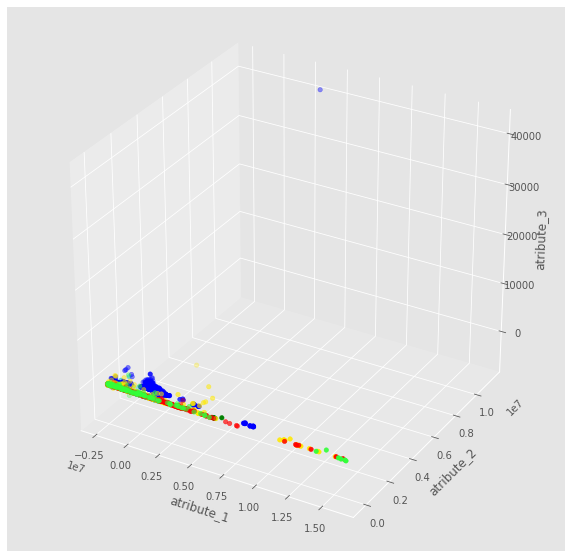

In [51]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', '#FFE800', '#33FF39', '#EC00FF', '#17becf']

for i in range(7):
    a = projected_x.loc[projected_x['target'] == i, 'atribute_1']
    b = projected_x.loc[projected_x['target'] == i, 'atribute_2']
    c = projected_x.loc[df['target'] == i, 'atribute_3']
    ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('atribute_1')
ax.set_ylabel('atribute_2')
ax.set_zlabel('atribute_3')
plt.show()

**Вывод:** при работе с методом минимальных компонент данные необходимо **нормировать**. То же самое касается некоторых других моделей.

# Методы работы с несбалансированными данными - up-sampling и down-sampling

Увеличим количество элементов в таблице для уравновешивания классов.

Будем использовать библиотеку imblearn

как установить в среде: https://imbalanced-learn.readthedocs.io/en/stable/install.html

Создадим тренировочный и тестовый датасет из исходных данных

In [52]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_norm,
                                                 Y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

# Up-sampling

Увеличим количество тренировочных данных (тестовые данные остаются нетронутыми)

In [54]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
print('Количество элементов до операции:', len(X_train))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 1358
Количество элементов после операции: 3248


Мы увеличили количество элементов, и уравняли классы по количеству

In [55]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

{0: 464, 1: 464, 2: 464, 3: 464, 4: 464, 5: 464, 6: 464}

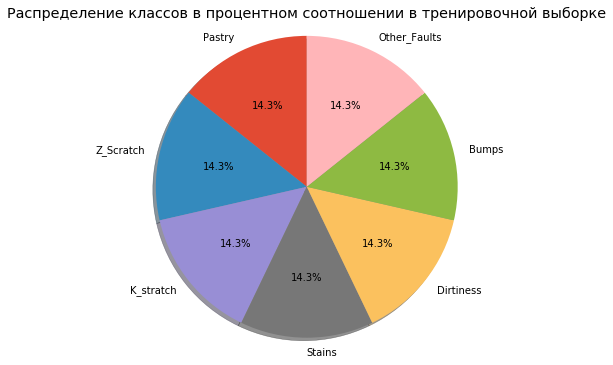

In [56]:
# Построем pie-график
labels = 'Pastry', 'Z_Scratch', 'K_stratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
sizes = [464, 464, 464, 464, 464, 464, 464]
explode = (0, 0, 0.0, 0, 0, 0.0, 0.0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots(figsize=(6, 6))
plt.title('Распределение классов в процентном соотношении в тренировочной выборке')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Но в **тестовых данных** остается несбалансированность. 

In [57]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 117, 1: 16, 2: 102, 3: 209, 4: 53, 5: 19, 6: 67}

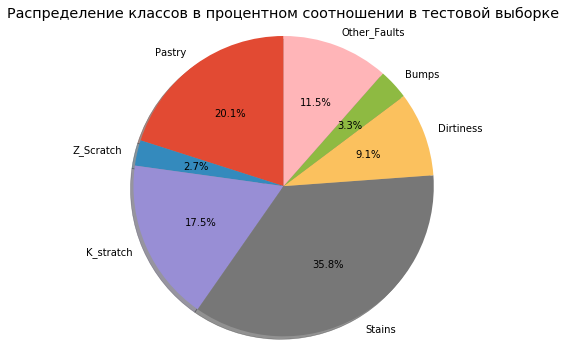

In [58]:
# Построем pie-график
labels = 'Pastry', 'Z_Scratch', 'K_stratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
sizes = [117, 16, 102, 209, 53, 19, 67]
explode = (0, 0, 0.0, 0, 0, 0.0, 0.0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6, 6))
plt.title('Распределение классов в процентном соотношении в тестовой выборке')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Мультиклассовая логистическая регрессия

Применим алгоритм логистической регрессии:

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       117
           1       1.00      0.81      0.90        16
           2       0.99      0.99      0.99       102
           3       1.00      1.00      1.00       209
           4       1.00      1.00      1.00        53
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        67

    accuracy                           0.99       583
   macro avg       0.99      0.97      0.98       583
weighted avg       0.99      0.99      0.99       583



Если бы данные были **не нормированы**

In [60]:
input_x = dataset_temp.iloc[:,:27]
input_x = input_x.drop(input_x[to_drop], axis=1)

In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(dataset_temp.iloc[:,:27],
                                                 Y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

In [62]:
ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
print('Количество элементов до операции:', len(X_train))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 1358
Количество элементов после операции: 3248


In [63]:
model = LogisticRegression()
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.34      0.44      0.38       117
           1       0.00      0.00      0.00        16
           2       0.55      0.80      0.66       102
           3       0.44      0.58      0.50       209
           4       0.00      0.00      0.00        53
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        67

    accuracy                           0.44       583
   macro avg       0.19      0.26      0.22       583
weighted avg       0.32      0.44      0.37       583



Все очень плохо. 44% точности всего

**Вывод:** **нормировать данные** для логистической регрессии также важно

# Модель Random Forest на сгенерированных данных

In [64]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_resampled, y_resampled)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       117
           1       0.87      0.81      0.84        16
           2       0.95      0.95      0.95       102
           3       0.73      0.75      0.74       209
           4       0.74      0.53      0.62        53
           5       0.95      0.95      0.95        19
           6       0.91      0.96      0.93        67

    accuracy                           0.79       583
   macro avg       0.83      0.81      0.82       583
weighted avg       0.79      0.79      0.79       583



Почему-то модель Random Forest показала результат не лучше, чем модель логистической регрессии, но при этом не лучше чем модель Random Forest, натренированная на исходных данных

# Пример кросс-валидации

Разделим датасет на 10 частей, предварительно перемешав все элементы между собой.

In [65]:
shuffled = df_norm
shuffled = shuffled.sample(frac=1)
shuffled = shuffled.reset_index(drop=True)

Будем проверять качество логистической регрессии с помощью **кросс-валидации**

In [66]:
from sklearn import metrics

part = len(shuffled)//10

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

mean_score = 0
for i in range(10):
    test = shuffled[i*part:(i+1)*part]
    train = shuffled.drop(shuffled.index[i*part:(i+1)*part])
    # обучаем модель
    train_x = train.drop(['target'], axis=1)
    train_y = train.target
    test_x = test.drop(['target'], axis=1)
    test_y = test.target
    model.fit(train_x, train_y)

    model_pred = model.predict(test_x)
    mean_score += metrics.accuracy_score(test_y, model_pred)
    
print(mean_score/10)

0.7814432989690722


Кросс-валидация показала, что точность алгоритма деревьев решений 78%

# Кривая ROC-Curve

# ROC-кривая датасет пациентов с сердечными болезнями

In [67]:
url="http://yustiks.ru/dataset/heart.csv"
data=pd.read_csv(url)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [68]:
X = data.drop('target', axis=1)
y = data.target

In [69]:
# разделим на тренировочные данные и на тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [70]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

В проблеме **классификации** модель предсказывает target значение, а также вероятность для данного класса. Отдельно вероятность предсказывается для каждого класса (их два в данном примерме: target 1 - человек здоров, target 0 -человек болен)

In [71]:
print('Предсказанный класс для тестовых данных (пациентов)')
print(model.predict(X_test))

Предсказанный класс для тестовых данных (пациентов)
[0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1
 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0
 0 0]


In [72]:
print('Предсказанные вероятности для каждого класса (0 и 1 соответственно)')
print(model.predict_proba(X_test[:4]))

Предсказанные вероятности для каждого класса (0 и 1 соответственно)
[[0.51571234 0.48428766]
 [0.0798293  0.9201707 ]
 [0.02711962 0.97288038]
 [0.40618686 0.59381314]]


Метод построения кривой ROC - библиотека skikitplot - https://readthedocs.org/projects/scikit-plot/downloads/pdf/stable/

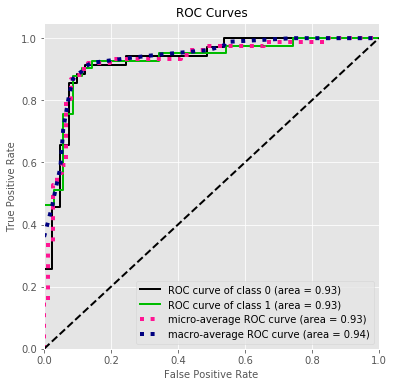

In [77]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test

y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas, figsize=(6, 6))
plt.show()

Text(0, 0.5, 'TPR')

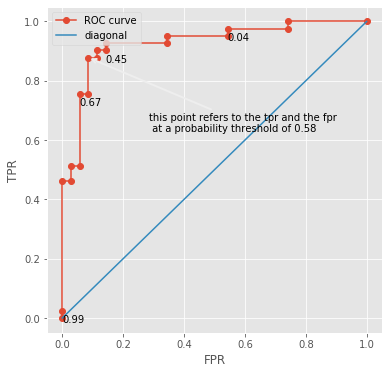

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas[:, 1])

# %%
plt.subplots(figsize=(6, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[1::5], tpr[1::5], thresholds[1::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 8
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

По графику получается, что можно отсекать все классы, вероятность предсказания которых (для target = 1) меньше 58%. 

# Линейная регрессия для временного ряда

Загрузим датасет "Цена на нефть" - https://www.kaggle.com/mabusalah/brent-oil-prices

In [79]:
import  datetime
#Convert date coulmns to specific format
dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
#Read csv file
url="http://yustiks.ru/dataset/BrentOilPrices.csv"
df = pd.read_csv(url,parse_dates=['Date'], date_parser=dateparse)

In [80]:

#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [81]:
# Print some data rows.
df.tail()

,Price
Date,
2019-09-24,64.13
2019-09-25,62.41
2019-09-26,62.08
2019-09-27,62.48
2019-09-30,60.99


# Будем предсказывать показания не на каждый месяц, а на начальный день каждого месяца


Сделаем resample данных на начало каждого месяца

Метод resample('..') может принимать следующие значения

```
...
CBM       custom business month end frequency
MS        month start frequency
SMS       semi-month start frequency (1st and 15th)
N         nanoseconds
...
```

таким образом мы будем предсказывать только цену на начало месяца

In [82]:
y = df['Price'].resample('MS').mean()

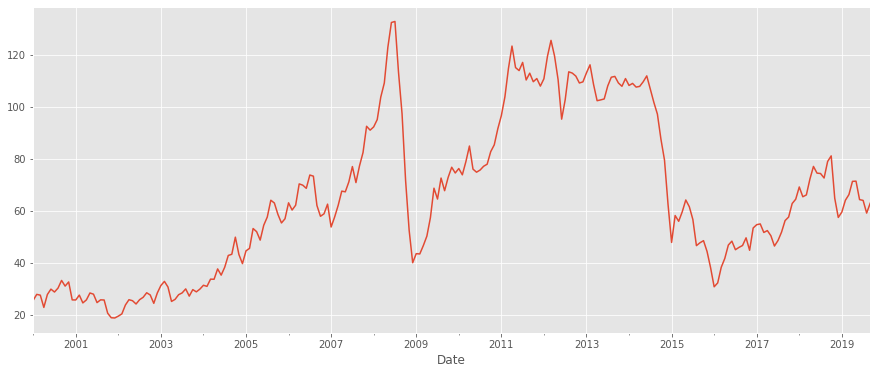

In [83]:
y.plot(figsize=(15, 6))
plt.show()

**Нормализуем данные**

In [84]:
sc = preprocessing.MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

**Делим датасет на тренировочный и на тестовый**

In [85]:
train_size = int(len(df) * 0.80)
test_size = int(len(df) * 0.20)
train, test = df[0:train_size, :], df[train_size:, :]

# Задача: по показаниям цены на нефть на 20 месяцев предсказать цену на 21 месяц

**Создаем вектор из временных интервалов (предсказываем какое будет значение на 21 день), с шагом = 1**

In [86]:
step = 20
overlap = 1
train_x = []
train_y = []
test_x = []
test_y = []
for i in range(0, train_size-step-2, overlap):
    train_x.append(train[i:i+step])
    train_y.append(train[i+step])
for i in range(0, test_size-step-2, overlap):
    test_x.append(test[i:i+step])
    test_y.append(test[i+step])    

In [87]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

Преобразуем исходные данные к виду массива:

In [88]:
new_train_x = []
for i in range(len(train_x)):
    mas = []
    for el in range(len(train_x[i])):
        mas.append(train_x[i][el][0])
    new_train_x.append(mas)
new_test_x = []
for i in range(len(test_x)):
    mas = []
    for el in range(len(test_x[i])):
        mas.append(test_x[i][el][0])
    new_test_x.append(mas)

In [89]:
model.fit(new_train_x, train_y)
model.score(new_test_x, test_y)

0.991012874157495

In [90]:
train_predict = model.predict(new_train_x)
test_predict = model.predict(new_test_x)

Так как данные нормированы, необходимо проделать обратную процедуры: из нормированной величины получить исходную

In [91]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform(train_y)
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform(test_y)

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('Средняя абсолютная ошибка при тренировке:', mean_absolute_error(Y_train, train_predict))
print('Средняя квадратичная ошибка при тренировке:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Средняя абсолютная ошибка на тестовых данных:', mean_absolute_error(Y_test, test_predict))
print('Средняя квадратичная ошибка на тестовых данных:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Средняя абсолютная ошибка при тренировке: 0.9509740281215467
Средняя квадратичная ошибка при тренировке: 1.3513903648596721
Средняя абсолютная ошибка на тестовых данных: 0.8847407263226229
Средняя квадратичная ошибка на тестовых данных: 1.1893947178036863


**Построим график тренировочных данных**

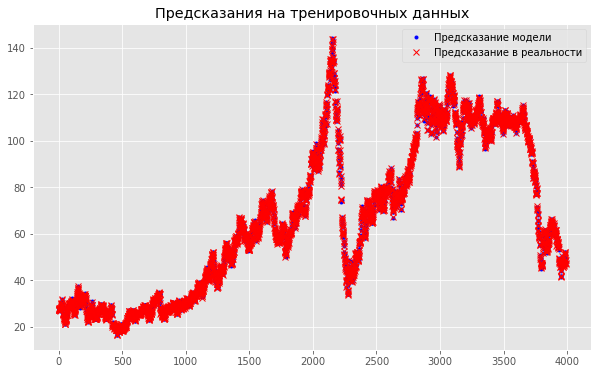

In [93]:
plt.figure(figsize=(10,6))
plt.title('Предсказания на тренировочных данных')
plt.plot(train_predict, 'b.')
plt.plot(Y_train, 'rx')
plt.legend(['Предсказание модели', 'Предсказание в реальности'])
plt.show()

**Построим график предсказания модели на тестовых данных**

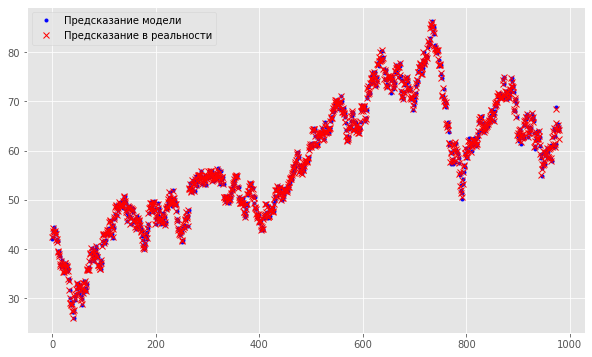

In [94]:
plt.figure(figsize=(10,6))
plt.plot(test_predict, 'b.')
plt.plot(Y_test, 'rx')
plt.legend(['Предсказание модели', 'Предсказание в реальности'])
plt.show()

Действительно, получили значения, очень близкие к тем, которые должны быть.